In [1]:
import pandas as pd
import numpy as np
import datetime
import scipy.sparse as spa
import cvxpy as cvx
from importlib import reload
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx

In [2]:
full_data = pd.read_csv("yellow_tripdata_2010-01.csv")
full_data['pickup_datetime'] = pd.to_datetime(full_data['pickup_datetime'])
full_data['dropoff_datetime'] = pd.to_datetime(full_data['dropoff_datetime'])

year = 2010
month = 1
day = 21
date = datetime.date(year, month, day)

day_data = full_data.loc[(full_data['pickup_datetime'].dt.date == date) & (full_data['dropoff_datetime'].dt.date == date)]
day_data = day_data[['pickup_datetime', 'dropoff_datetime', 'trip_distance', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'fare_amount', 'surcharge', 'mta_tax', 'tip_amount', 'tolls_amount', 'total_amount']]
day_data = day_data.loc[(day_data['pickup_longitude'] != 0) & (day_data['pickup_latitude'] != 0)]

n = 100
data = day_data.sample(n).sort_values(by='pickup_datetime')
data.index = range(n)
data

C:\Users\holly\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3147: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,pickup_datetime,dropoff_datetime,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,2010-01-21 00:22:53,2010-01-21 00:26:42,0.60,-73.972892,40.753493,-73.976588,40.751236,4.1,0.5,0.5,0.0,0.0,5.1
1,2010-01-21 00:38:00,2010-01-21 00:44:00,2.33,-73.937557,40.757952,-73.936700,40.758235,7.3,0.5,0.5,0.0,0.0,8.3
2,2010-01-21 01:18:51,2010-01-21 01:23:12,1.00,-74.002338,40.733753,-73.994151,40.738728,4.9,0.5,0.5,0.0,0.0,5.9
3,2010-01-21 01:39:00,2010-01-21 01:47:00,2.74,-73.977748,40.778827,-73.971238,40.751387,8.5,0.5,0.5,0.0,0.0,9.5
4,2010-01-21 03:14:58,2010-01-21 03:19:33,1.00,-74.005821,40.741153,-73.991471,40.742217,4.9,0.5,0.5,0.0,0.0,5.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2010-01-21 23:15:48,2010-01-21 23:33:34,4.10,-73.990166,40.762230,-74.010611,40.717740,13.7,0.5,0.5,0.0,0.0,14.7
96,2010-01-21 23:26:00,2010-01-21 23:35:00,1.40,-73.987388,40.729080,-73.996470,40.712203,6.9,0.5,0.5,0.0,0.0,7.9
97,2010-01-21 23:39:00,2010-01-21 23:41:00,0.41,-73.953258,40.775913,-73.954792,40.780190,3.3,0.5,0.5,0.0,0.0,4.3
98,2010-01-21 23:39:09,2010-01-21 23:48:25,1.80,-73.988292,40.723202,-74.006408,40.706567,7.7,0.5,0.5,2.5,0.0,11.2


## Vector Formulation

In [3]:
import class_TP
reload(class_TP)
from class_TP import TP

In [4]:
tp = TP(data)
t, x, problem = tp.problem_param()
t_vals = np.zeros(t.shape)
t_min, _ = tp.time_cons()
t_vals = t_min

t_range = 1
step = .1
dim = int(t_range/step)
heat_map = np.zeros((dim, dim))
i = 0
for t0 in np.arange(0, t_range, step):
    for t1 in np.arange(0, t_range, step):
            t_vals[0] = t_min[0] + t0
            t_vals[1] = t_min[1] + t1
            t.value = t_vals
            problem.solve()
            obj_val = problem.objective.value
            heat_map[int(i/dim), i%dim] = obj_val
            i += 1

            print(t.value[0], t.value[1])
            print("Objective Value:", obj_val)
            run_time = problem.solver_stats.solve_time
            print("Run Time:", run_time)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all().

In [ ]:
plt.imshow(heat_map, cmap='hot', interpolation='nearest')
plt.show()

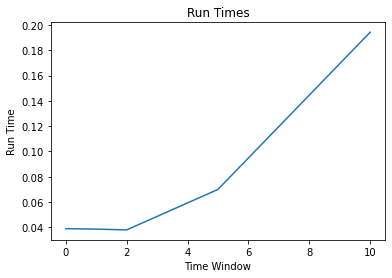

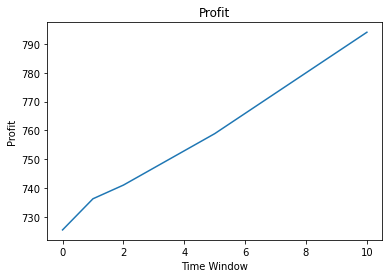

In [8]:
time_windows = [0, 1, 2, 5, 10]
run_times = []
obj_val = []

tp = TP(data)
for time_window in time_windows:
    x, problem = tp.problem(time_window)
    
    sims = 10
    run_time = 0
    for i in range(sims):
        problem.solve()
        run_time += problem.solver_stats.solve_time
    run_times.append(run_time/sims)
    obj_val.append(problem.objective.value)
#     print("Time Window:", time_window)
#     print("Run Time:", run_time/sims)
#     print("Objective Value:", problem.objective.value)
    
#     x_val = spa.dok_matrix((tp.num_nodes, tp.num_nodes))
#     for a in range(tp.num_arcs):
#         x_val[tp.arcs[a]] = x[a].value
#     print(x_val.tocoo())

plt.figure(1)
plt.plot(time_windows, run_times);
plt.title("Run Times");
plt.xlabel("Time Window");
plt.ylabel("Run Time");
plt.figure(2)
plt.plot(time_windows, obj_val);
plt.title("Profit");
plt.xlabel("Time Window");
plt.ylabel("Profit");

In [ ]:
run_times

## Map
Needs updating

In [ ]:
x_val = spa.dok_matrix((n+taxis+2, n+taxis+2))
for i in range(n+taxis+2):
    for j in s_list[i]:
        x_val[i,j] = x[arcs.get((i,j))].value
print("Time Window:", time_window)
print(x_val.tocoo())
print(objective.value)

In [ ]:
arcs = np.asarray(np.nonzero(x_val))
# locs = np.unique(arcs[arcs < 200])
# lons = data.iloc[locs, 3]
# lats = data.iloc[locs, 4]

loc_origin = arcs[0][:-taxis-2]
loc_destin = arcs[1][:-taxis-2]

lon_origin = data.iloc[loc_origin, 3].to_numpy()
lat_origin = data.iloc[loc_origin, 4].to_numpy()
lon_destin = data.iloc[loc_destin, 3].to_numpy()
lat_destin = data.iloc[loc_destin, 4].to_numpy()

In [ ]:
# from shapely.geometry import Point, LineString
from matplotlib.patches import FancyArrowPatch

nyc = gpd.read_file(gpd.datasets.get_path('nybb'))
# nyc = nyc.to_crs(epsg=3857)
nyc = nyc.to_crs(epsg=4326)
ax = nyc.plot(figsize=(20, 20), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax)

ax.set_xlim(-74.05, -73.85)
ax.set_ylim(40.68, 40.82)

# nodes = gpd.GeoDataFrame(geometry=gpd.points_from_xy(lons, lats))
# nodes.plot(color='green')

fig = plt.figure()

# One Taxi's Journey
taxi_num = n + 1
node = arcs[1][np.where(arcs[0] == taxi_num)] # First node (rider) for given taxi
while True:
    where = np.array(np.where(loc_origin == node))
    if (where.size == 0): break
    i = where[0][0]
    dx = lon_destin[i] - lon_origin[i]
    dy = lat_destin[i] - lat_origin[i]
    ax.arrow(lon_origin[i], lat_origin[i], dx, dy, color = 'pink', width=.0004)
    node = loc_destin[i]

plt.show()